# 1. Imports and definiiton

In [1]:
# import the library
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import calendar
import numpy as np
import matplotlib.dates as mdates
import sys
import os
from os import listdir
from os.path import isfile, join
from dateutil import parser
import re
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (GradientBoostingRegressor, 
                              RandomForestRegressor, 
                              AdaBoostRegressor, 
                              BaggingRegressor, 
                              ExtraTreesRegressor,
                              HistGradientBoostingRegressor,
                              StackingRegressor,
                              VotingRegressor)
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import seaborn as sns
import matplotlib.colors as mcolors
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from datetime import datetime, timedelta
from matplotlib import animation
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.impute import SimpleImputer
# from func_defs import *

# %matplotlib ipympl


# define the filename


# define the plot template
axis_label_size = 15
axis_num_size = 12
text_size = 12
title_size = 22

# define the figure size for single plot
figure_size = (6, 6)
subplot_size_1_2 = (6, 6)
long_hoz_figsize = (12, 6)

# 2. Electrical data visualisation

            Timestamp  Power
0 2020-06-01 00:00:00    0.0
1 2020-06-01 00:05:00    0.0
2 2020-06-01 00:10:00    0.0
3 2020-06-01 00:15:00    0.0
4 2020-06-01 00:20:00    0.0


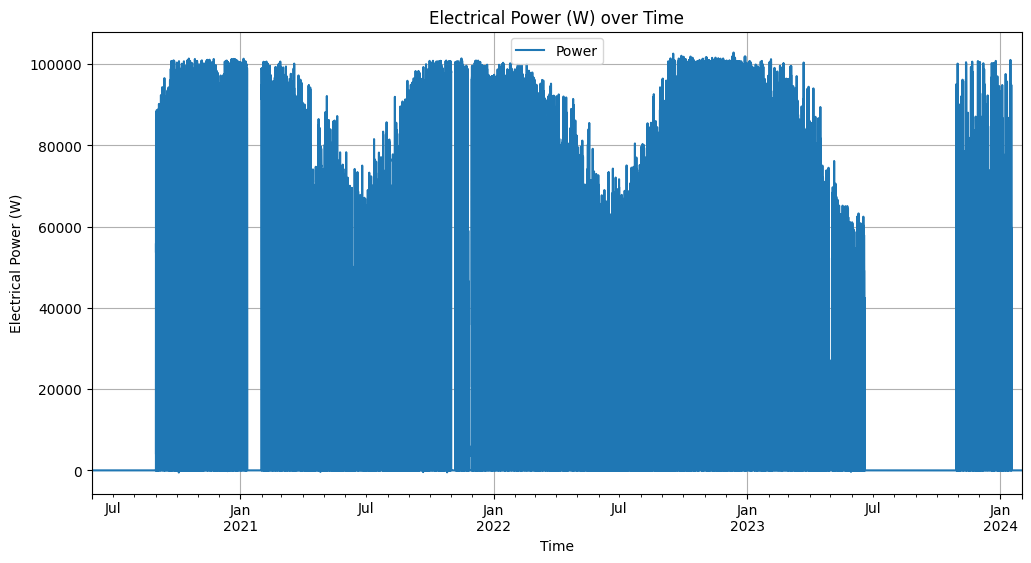

In [2]:
# Load the data from the pickle file
data_file = r"C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\25_08_26_Bomen_bifacial_gain\Data\full_site_pow_5min.pkl"
df = pd.read_pickle(data_file)

# print the head
print(df.head())

# plot the data, it only has one column
df.plot(x = 'Timestamp', y='Power', figsize=long_hoz_figsize)
plt.title('Electrical Power (W) over Time')
plt.xlabel('Time')
plt.ylabel('Electrical Power (W)')
plt.grid()
plt.show()

# 3. Weather data visualisation for PVsyst input weather data

Index(['Timestamp', 'Air Humidity (Avg )_median', 'Air Pressure (Avg )_median',
       'Air Temperature mean (Avg )_median',
       'Albedo Irradiance mean (Avg )_median',
       'GHI Irradiance mean (Avg )_median',
       'POA Irradiance mean (Avg )_median', 'Wind Direction (Avg )_median',
       'Wind Speed mean (Avg )_median', 'albedo_ratio_median',
       'albedo_ratio_resampled_median', 'Wind Speed (10m) mean (Avg )_median',
       'Air Temperature mean (Avg )', 'GHI Irradiance mean (Avg )'],
      dtype='object')

=== MISSING DATA ANALYSIS ===
NaN values in Timestamp column: 0
Most common time difference: 0 days 00:05:00
Detected data frequency: 5min
Total expected timestamps: 105120
Actual unique timestamps: 105120
Missing timestamps: 0 (0.00%)

Humidity column found: ['Air Humidity (Avg )_median']
Temperature column found: ['Air Temperature mean (Avg )_median']
GHI column found: ['GHI Irradiance mean (Avg )']
Wind speed column found: ['Wind Speed (10m) mean (Avg )_median']

===

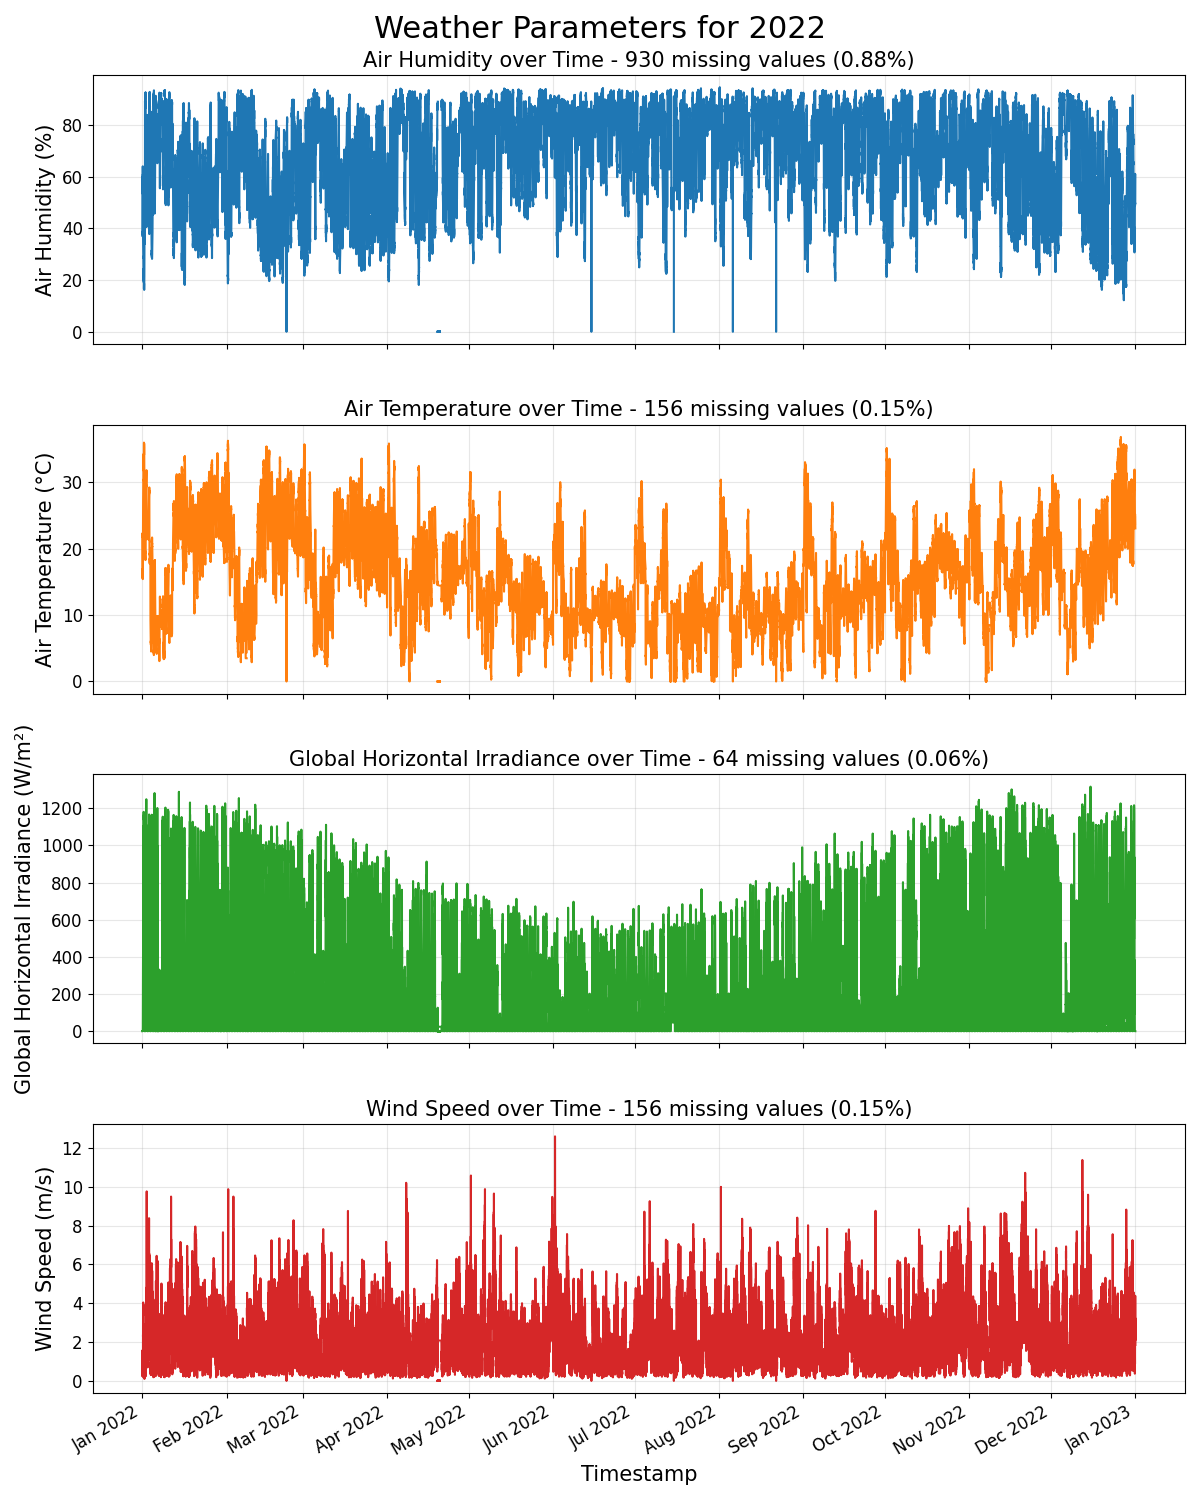

In [3]:
%matplotlib ipympl

# the weather data file directory
PVsyst_weather = r"C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\25_08_26_Bomen_bifacial_gain\Results\PVsyst_weather_2022.csv"

# read the csv file from the directory
PVsyst_weather_df = pd.read_csv(PVsyst_weather)

# print the columns
print(PVsyst_weather_df.columns)

# ensure the Timestamp column is in datetime format
PVsyst_weather_df['Timestamp'] = pd.to_datetime(PVsyst_weather_df['Timestamp'], errors='coerce')

# Check for missing timestamps
print("\n=== MISSING DATA ANALYSIS ===")

# Check if there are any NaN timestamps
nan_timestamps = PVsyst_weather_df['Timestamp'].isna().sum()
print(f"NaN values in Timestamp column: {nan_timestamps}")

# Calculate the expected time frequency based on the most common time difference
time_diffs = PVsyst_weather_df['Timestamp'].dropna().sort_values().diff().value_counts()
most_common_diff = time_diffs.index[0]
print(f"Most common time difference: {most_common_diff}")

# Create a complete timestamp range based on detected frequency
min_timestamp = PVsyst_weather_df['Timestamp'].min()
max_timestamp = PVsyst_weather_df['Timestamp'].max()
expected_freq = 'H'  # Default to hourly if we can't detect
if most_common_diff <= pd.Timedelta(minutes=10):
    expected_freq = '5min'
elif most_common_diff <= pd.Timedelta(minutes=20):
    expected_freq = '15min'
elif most_common_diff <= pd.Timedelta(minutes=40):
    expected_freq = '30min'
elif most_common_diff <= pd.Timedelta(hours=1.5):
    expected_freq = 'H'
else:
    expected_freq = 'D'

print(f"Detected data frequency: {expected_freq}")
expected_timestamps = pd.date_range(start=min_timestamp, end=max_timestamp, freq=expected_freq)
actual_timestamps = PVsyst_weather_df['Timestamp'].dropna().unique()

missing_timestamps = len(expected_timestamps) - len(actual_timestamps)
print(f"Total expected timestamps: {len(expected_timestamps)}")
print(f"Actual unique timestamps: {len(actual_timestamps)}")
print(f"Missing timestamps: {missing_timestamps} ({missing_timestamps/len(expected_timestamps)*100:.2f}%)")

# Find the columns for each parameter - using specific column names
humidity_col = [col for col in PVsyst_weather_df.columns if 'Air Humidity' in col and 'median' in col]
temperature_col = [col for col in PVsyst_weather_df.columns if 'Air Temperature' in col and 'median' in col]
# Changed to use 'GHI Irradiance mean (Avg )' instead of the median version
ghi_col = ['GHI Irradiance mean (Avg )'] if 'GHI Irradiance mean (Avg )' in PVsyst_weather_df.columns else []
# Specify the exact wind speed column name
wind_speed_col = ['Wind Speed (10m) mean (Avg )_median'] if 'Wind Speed (10m) mean (Avg )_median' in PVsyst_weather_df.columns else []

# Print which columns were found
print(f"\nHumidity column found: {humidity_col}")
print(f"Temperature column found: {temperature_col}")
print(f"GHI column found: {ghi_col}")
print(f"Wind speed column found: {wind_speed_col}")

# Collect found columns or notify if missing
parameters = [
    (humidity_col, 'Air Humidity', '%'),
    (temperature_col, 'Air Temperature', '°C'),
    (ghi_col, 'Global Horizontal Irradiance', 'W/m²'),
    (wind_speed_col, 'Wind Speed', 'm/s')
]

# Count missing values in each parameter column
print("\n=== MISSING VALUES BY PARAMETER ===")
for col_list, param_name, unit in parameters:
    if col_list:
        col = col_list[0]
        missing_count = PVsyst_weather_df[col].isna().sum()
        missing_percent = (missing_count / len(PVsyst_weather_df)) * 100
        print(f"{param_name}: {missing_count} missing values ({missing_percent:.2f}%)")
    else:
        print(f"{param_name}: No column found")

# Create a figure with 4 subplots stacked vertically
fig, axes = plt.subplots(4, 1, figsize=(12, 15), sharex=True)

# Lists to store column names and corresponding labels
columns = []
labels = []
units = []

# Plot each parameter in its own subplot
for i, (col_list, param_name, unit) in enumerate(parameters):
    ax = axes[i]
    
    if col_list:
        col = col_list[0]  # Take the first match
        
        # Count missing values for this parameter
        missing_count = PVsyst_weather_df[col].isna().sum()
        missing_percent = (missing_count / len(PVsyst_weather_df)) * 100
        
        ax.plot(PVsyst_weather_df['Timestamp'], PVsyst_weather_df[col], 
                linewidth=1.5, color=f'C{i}')
        ax.set_ylabel(f'{param_name} ({unit})', fontsize=axis_label_size)
        ax.set_title(f'{param_name} over Time - {missing_count} missing values ({missing_percent:.2f}%)', 
                     fontsize=axis_label_size)
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='both', which='major', labelsize=axis_num_size)
        
        # Print statistics for this parameter
        print(f"\nStatistics for {col}:")
        print(f"Min: {PVsyst_weather_df[col].min():.2f} {unit}")
        print(f"Max: {PVsyst_weather_df[col].max():.2f} {unit}")
        print(f"Mean: {PVsyst_weather_df[col].mean():.2f} {unit}")
        print(f"Median: {PVsyst_weather_df[col].median():.2f} {unit}")
    else:
        ax.text(0.5, 0.5, f"No {param_name} data found", 
                ha='center', va='center', fontsize=12, transform=ax.transAxes)
        print(f"No column found for {param_name}")

# Format the shared x-axis
axes[-1].set_xlabel('Timestamp', fontsize=axis_label_size)
axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
axes[-1].xaxis.set_major_locator(mdates.MonthLocator())

# Rotate date labels for better readability
fig.autofmt_xdate()

# Add an overall title
fig.suptitle('Weather Parameters for 2022', fontsize=title_size, y=0.99)

# Adjust spacing between subplots
plt.tight_layout()
plt.subplots_adjust(top=0.95, hspace=0.3)

# Show the plot
plt.show()

# 3. Simulation results visualisation

## 3.1. Data loading

In [4]:
# simulation results directory
simulation_results_dir = r"C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\25_08_26_Bomen_bifacial_gain\Data\25_08_25_Bowen Solar Farm 2022_VCG_HourlyRes_1.CSV"

# Read the CSV file with specific parameters
simulation_results_df = pd.read_csv(
    simulation_results_dir, 
    skiprows=10,     # Skip the first 10 rows to get to header at row 11
    header=0,        # Use the first row after skipping as header
    sep=';',         # Use semicolon as delimiter
    encoding='latin-1',  # Keep the encoding that worked
    dayfirst=True,
    skipfooter=0     # Skip no rows at the end
)

# ensure that the 'date' column is in datetime format
simulation_results_df['date'] = pd.to_datetime(simulation_results_df['date'], errors='coerce')
# rename it as 'timestamp'
simulation_results_df.rename(columns={'date': 'timestamp'}, inplace=True)
# remove the first row of data
simulation_results_df = simulation_results_df.iloc[1:]


# print the columns
print("\nColumns:")
print(simulation_results_df.columns.tolist())

# print whether 'EArray' column exists
print(f"Does 'EArray' column exist? {'EArray' in simulation_results_df.columns}")

# print the timestamp column in july
print(simulation_results_df[simulation_results_df['timestamp'].dt.month == 7]['timestamp'])

C:\Users\z5183876\AppData\Local\Temp\ipykernel_43660\3970972206.py:5: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153) have mixed types. Specify dtype option on import or set low_memory=False.
  simulation_results_df = pd.read_csv(
C:\Users\z5183876\AppData\Local\Temp\ipykernel_43660\3970972206.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  simulation_results_df['date'] = 


Columns:
['timestamp', 'HSol', 'AzSol', 'AngInc', 'AngProf', 'PlTilt', 'PlAzim', 'PhiAng', 'GlobHor', 'DiffHor', 'BeamHor', 'T_Amb', 'WindVel', 'PrecWat', 'BeamTrp', 'DifITrp', 'CircTrp', 'HBndTrp', 'AlbTrp', 'GlobTrp', 'GincThr', 'GlobInc', 'BeamInc', 'CircInc', 'DifSInc', 'Alb_Inc', 'Bm_Gl', 'DifA_Gl', 'DifS_Gl', 'Alb_Gl', 'GlobShd', 'ShdLoss', 'ShdBLss', 'ShdCLss', 'ShdDLss', 'ShdALss', 'GlobIAM', 'IAMLoss', 'IAMBLss', 'IAMCLss', 'IAMDLss', 'IAMALss', 'GlobSlg', 'SlgLoss', 'SlgBLss', 'SlgCLss', 'SlgDLss', 'SlgALss', 'GlobEff', 'BeamEff', 'CircEff', 'DiffEff', 'Alb_Eff', 'GlobGnd', 'ReflLss', 'BkVFLss', 'DifSBak', 'BackShd', 'GlobBak', 'ReflFrt', 'ReflBck', 'BmIncBk', 'BmSFBak', 'BIAMFBk', 'BeamBak', 'FTransp', 'FShdGl', 'FShdBm', 'FShdCrc', 'FShdDif', 'FShdAlb', 'FIAMGl', 'FIAMBm', 'FIAMCrc', 'FIAMDif', 'FIAMAlb', 'FSlgGl', 'FSlgBm', 'FSlgCrc', 'FSlgDif', 'FSlgAlb', 'FIAMShd', 'FEffDif', 'FEffAlb', 'EArrRef', 'EArrNom', 'DegrLss', 'GIncLss', 'TempLss', 'SpctCor', 'ModQual', 'LIDLos

## 3.2. Visualisation

### 3.2.1. Hourly

Converted EArray column from string to numeric
EArray Min: 0.00 MW
EArray Max: 118.16 MW
EArray Mean: 22.14 MW
Total data points: 8760


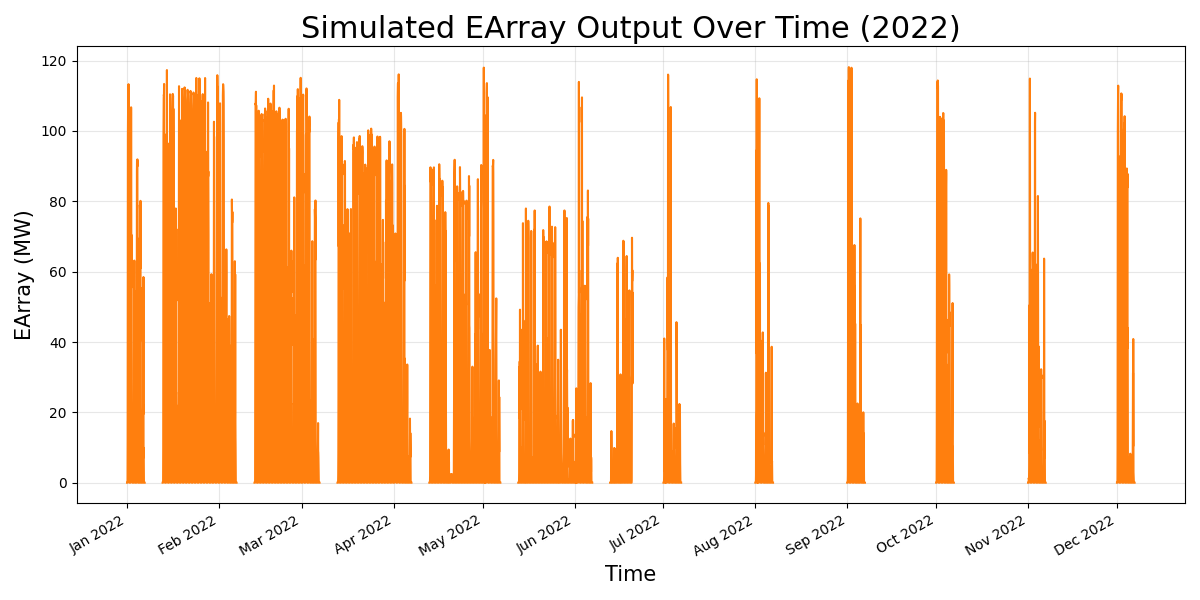

In [5]:
# First check if EArray needs conversion (avoid error if already numeric)
if pd.api.types.is_object_dtype(simulation_results_df['EArray']):
    # Only convert if it's still a string/object type
    simulation_results_df['EArray'] = pd.to_numeric(
        simulation_results_df['EArray'].str.replace(',', '.'), 
        errors='coerce'
    )
    print("Converted EArray column from string to numeric")
else:
    print("EArray column is already numeric type:", simulation_results_df['EArray'].dtype)

# ensure the timestamp column is index and is in datetime column and sorted
simulation_results_df.set_index('timestamp', inplace=True)
simulation_results_df.sort_index(inplace=True)

# plot the 'EArray' column over time
plt.figure(figsize=long_hoz_figsize)

# Plot EArray data
plt.plot(simulation_results_df['EArray'], 
         linewidth=1.5, color='#ff7f0e')

# Add labels and title
plt.xlabel('Time', fontsize=axis_label_size)
plt.ylabel('EArray (MW)', fontsize=axis_label_size)
plt.title('Simulated EArray Output Over Time (2022)', fontsize=title_size)

# Add grid
plt.grid(True, alpha=0.3)

# Format the date on x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

# Rotate date labels for better readability
plt.gcf().autofmt_xdate()

# Adjust layout
plt.tight_layout()

# Print some statistics
print(f"EArray Min: {simulation_results_df['EArray'].min():.2f} MW")
print(f"EArray Max: {simulation_results_df['EArray'].max():.2f} MW")
print(f"EArray Mean: {simulation_results_df['EArray'].mean():.2f} MW")
print(f"Total data points: {len(simulation_results_df)}")

# Show plot
plt.show()

### 3.2.2. Hourly